# 1. 서울시 스타벅스 매장 정보 데이터 베이스에 저장

<img src="https://lh6.googleusercontent.com/d4GRksXveUm4kJyKaUZp0QNgpf0vJ6UYfrqWuHmeIMnDBd7qTYaYuWeKvo4CbGBKTHyJFCsqX4VB6mUo0fiOqM1QPkkppHrFvWSrYIKJbN4K5pHyOXaNoYZcNi870mydgg=w2032" width=1000 height=500 alt='스타벅스 매장 찾기 창'>

### 1.0 html 구조 분석
<hr> 

- [스타벅스->매장찾기](https://www.starbucks.co.kr/store/store_map.do)로 접속 시 '퀵 검색' 탭이 활성화
- '지역 검색' 탭 -> header class="loca_search"
- **서울**: div class="loca_step1_cont" 내부에 
> a href="javascript:void(0);" class="set_sido_cd_btn" data-sidocd="01">서울
- **전체**: div class="loca_step2_cont" 내부에 
> a href="javascript:void(0);" class="set_gugun_cd_btn" data-sidocd="01" data-sidonm="서울" data-guguncd="">전체
- **매장정보** class="quickSearchResultBoxSidoGugun" 내부의 class=quickResultLstCon에 

|정보|구분 방법|
|:---|:---|
|위도|data-lat="위도 좌표"|
|경도|data-long="경도 좌표"|
|인덱스|data-index="인덱스"|
|매장명|data-name="매장명"|

class="result_details"에 P로 묶인 부분 -> 매장 주소, br로 묶인 부분 -> 매장 전화번호. 아래 예시.
> li class="quickResultLstCon" style="background:#fff" data-lat="37.501087" data-long="127.043069" data-index="0" data-name="역삼아레나빌딩" data-code="3762" data-storecd="1509" data-hlytag="null">	strong data-store="1509" data-yn="N" data-name="역삼아레나빌딩" data-my_siren_order_store_yn="N">역삼아레나빌딩  /strong>	p class="result_details">서울특별시 강남구 언주로 425 (역삼동)br>1522-3232/p>	i class="pin_general">리저브 매장 2번/i>/li>

### 1.1 전략
> 1. [스타벅스 매장 찾기 창](https://www.starbucks.co.kr/store/store_map.do)으로 접속.
> 2. **selenium**, 클릭: '지역 검색' -> '서울' -> '전체'.
> 3. **Beautiful Soup**, 서울 전체 스타벅스 매장 정보를 크롤링. -> 데이터 프레임으로 저장.
> 4. "Edia_one_day" AWS DB에 "edia" 사용자로 접속.
> 5. DB내 "starbucks" 테이블 생성 및 데이터 프레임 내용으로 INSERT.

### 1.2 구현

##### 1.2.1 Import

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import ElementNotInteractableException
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.support.select import Select
import time
from tqdm.notebook import tqdm
from glob import glob
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
from user_agent import generate_user_agent
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import json
import folium
import warnings
import numpy as np
import requests
import re
import mysql.connector
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

/tmp/ipykernel_2315/2786053356.py:18: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


##### 1.2.2 selenium으로 '스타벅스 매장 찾기' 창의 URL 접속

In [11]:
url = "https://www.starbucks.co.kr/store/store_map.do"
driver = webdriver.Chrome(service=Service("../driver/chromedriver"))
driver.get(url)

##### 1.2.3 selenium, 클릭: '지역 검색' -> '서울' -> '전체'

In [12]:
local_search = driver.find_element(By.CLASS_NAME, "loca_search")
local_search.click()

In [13]:
local_Seoul = driver.find_element(By.CSS_SELECTOR, 'a[data-sidocd="01"]')
local_Seoul.click()

In [14]:
local_Seoul = driver.find_element(By.CSS_SELECTOR, 'a[data-guguncd=""]')
local_Seoul.click()

##### 1.2.4 Beautiful Soup, HTML 가져오기

In [15]:
# 웹페이지에 접속하여 HTML 가져오기
html = driver.page_source
response = requests.get(url)
soup = BeautifulSoup(html, 'html.parser')

##### 1.2.5 Beautiful Soup, 기본 데이터(매장명, 주소, 위치) 추출

In [16]:
store_data = []
existing_coordinates = set() # For checking duplication by coordinate

for element in soup.find_all('li', class_='quickResultLstCon'):
    store_name = element['data-name']
    address_phone = element.find('p', class_='result_details').get_text(strip=True)
    address_phone_match = re.match(r'(.+?)(\d{4}-\d{4})', address_phone)
    address = address_phone_match.group(1)
    phone_number = address_phone_match.group(2)
    latitude = element['data-lat']
    longitude = element['data-long']
    
    # checking coordinate
    if (latitude, longitude) in existing_coordinates:
        continue 
    else:
        existing_coordinates.add((latitude, longitude))  # add coordinate to coordinate checking set 
    
    store_data.append({
        '매장명': store_name,
        '주소': address,
        '대표번호': phone_number,
        '위도': latitude,
        '경도': longitude
    })

# DataFrame
starbucks_seoul = pd.DataFrame(store_data)
print(starbucks_seoul)

          매장명                                           주소       대표번호  \
0      가산에스케이      서울특별시 금천구 가산디지털1로 171 (가산동), SK V1센터 1층  1522-3232   
1       가산디지털  서울특별시 금천구 가산디지털1로 168 (가산동), 우림라이온스밸리 B동 1층  1522-3232   
2      가산브이타워      서울특별시 금천구 가산디지털1로 128 (가산동), V-TOWER 1층  1522-3232   
3      마리오아울렛                   서울특별시 금천구 벚꽃로 266 마리오아울렛3관  1522-3232   
4    가산디지털단지역       서울특별시 금천구 벚꽃로 298 (가산동), 대륭포스트타워 6차 1층  1522-3232   
..        ...                                          ...        ...   
608      사가정역                            서울특별시 중랑구 면목로 310  1522-3232   
609       상봉역                      서울특별시 중랑구 망우로 307 (상봉동)  1522-3232   
610        묵동        서울특별시 중랑구 동일로 952 (묵동, 로프트원 태릉입구역) 1층  1522-3232   
611       양원역                    서울특별시 중랑구 양원역로10길 3 (망우동)  1522-3232   
612       중화역                         서울특별시 중랑구 봉화산로 35 1층  1522-3232   

                    위도                  경도  
0          37.48061318         126.8805702  
1           37.4798346  126.88249

In [17]:
starbucks_seoul.to_excel("../data/starbucks.xlsx", index=False)

##### 1.2.6 Selenium & Beautiful Soup, 상세 데이터(매장 타입, 서비스, 인프라 및 시설) 추출 -> 추후 보완
<hr>

1. selenium으로 서울시 전체 매장 클릭
2. 아이콘 존재 여부로 매장별 상세 데이터 파악. 

> <center> 참고 </center> 
> <br>

> - 옵션 선택에 아이콘과 그 이름이 있어서 팝업에 있는 아이콘의 src 주소와 라벨링이 같다고 생각. -> 아님..
> - 팝업 화면의 매장 서비스 아이콘의 라벨링 전부 찾아보기.
> - icon_charging -> 전기차 충전소; 옵션 선택으로서 아이콘에는 있지만, 전국에 이 서비스를 제공하는 곳 X -> 팝업에 안 나옴 -> 일해라 스타벅스 코리아

스타벅스 매장 서비스 아이콘 확인 icon(01~문자열), 중간에 없는 번호는 NULL
> 주소 양식: img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon(라벨).png" 

|아이콘: 의미|아이콘: 의미|아이콘: 의미|아이콘: 의미|
|:---|:---|:---|:---|
|<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon01.png" width=30 height=30> icon01: 스타벅스 리저브™|<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon02.png" width=30 height=30> icon02:커뮤니티 스토어|<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon03.png" width=30 height=30> icon03: 드라이브 스루|<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon04.png" width=30 height=30> icon04:주차|
|<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon05.png" width=30 height=30> icon05: 외화 결재|<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon07.png" width=30 height=30> icon07: 공항내|<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon08.png" width=30 height=30> icon08: 대학가|<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon09.png" width=30 height=30> icon09: 해안가|
|<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon10.png" width=30 height=30> icon10: 입점|<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon11.png" width=30 height=30> icon11: 리조트|<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon12.png" width=30 height=30> icon12: 터미널/기차역|<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon13.png" width=30 height=30> icon13: 병원|
|<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon14.png" width=30 height=30> icon14: 지하철 인접|<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon18.png" width=30 height=30> icon18: 나이트로 콜드 브루 커피|<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon19.png" width=30 height=30> icon19: 장애인 편의 시설|<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon20.png" width=30 height=30> icon20: 현금없는 매장|
|<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon21.png" width=30 height=30> icon21: 공기청정기|<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon22.png" width=30 height=30> icon22: 피지오|<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon23.png" width=30 height=30> icon23: 블론드|<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon24.png" width=30 height=30> icon24: 식약처 위생등급제 인증|
|<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon_eco_service.png" width=30 height=30> icon_eco_service: 에코 매장|<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon_delivers_service.png" width=30 height=30> icon_delivers_service: 딜리버스|<img src="https://image.istarbucks.co.kr/upload/common/img/icon/Moon_icon_16x16_230324.png" width=30 height=30> Moon_icon_16x16_230324: 21시 종료 매장|

서비스 아이콘 중 Ediya 분석에 필요없는 정보는 제외 -> 위치 관련 서비스만 데이터 프레임에 추가함.

<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon03.png" width=30 height=30> icon03: 드라이브 스루
<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon04.png" width=30 height=30> icon04:주차 
<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon07.png" width=30 height=30> icon07: 공항내
<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon08.png" width=30 height=30> icon08: 대학가  
<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon09.png" width=30 height=30> icon09: 해안가
<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon10.png" width=30 height=30> icon10: 입점
<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon12.png" width=30 height=30> icon12: 터미널/기차역
<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon13.png" width=30 height=30> icon13: 병원 \
<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon14.png" width=30 height=30> icon14: 지하철 인접
<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon19.png" width=30 height=30> icon19: 장애인 편의 시설 \
<img src="https://image.istarbucks.co.kr/upload/common/img/icon/icon_delivers_service.png" width=30 height=30> icon_delivers_service: 딜리버스
<img src="https://image.istarbucks.co.kr/upload/common/img/icon/Moon_icon_16x16_230324.png" width=30 height=30> Moon_icon_16x16_230324: 21시 종료 매장

In [ ]:
for element in driver.find_elements(By.CSS_SELECTOR, 'li.quickResultLstCon'):
    try:
        element.click()
        time.sleep(0.3)
    
    except ElementNotInteractableException:
        print("shit!")
        continue  # 클릭할 수 없는 요소를 만나면 반복문 종료

<div id="mCSB_3_dragger_vertical" class="mCSB_dragger mCSB_dragger_onDrag" style="position: absolute; min-height: 30px; top: 0px; display: block; height: 1px; max-height: 284px;" oncontextmenu="return false;"><div class="mCSB_dragger_bar" style="line-height: 30px;"></div></div>

In [9]:
driver.close()

##### 1.2.7 DB에 저장

In [18]:
remote = mysql.connector.connect(
    host = "database-1.cdv9nppqt3kw.ap-northeast-2.rds.amazonaws.com",
    port = 3306,
    user = "ediya",
    password = "0523",
    database = "Ediya_one_day"
)

In [19]:
starbucks_seoul

매장명                                           주소       대표번호  \
0      가산에스케이      서울특별시 금천구 가산디지털1로 171 (가산동), SK V1센터 1층  1522-3232   
1       가산디지털  서울특별시 금천구 가산디지털1로 168 (가산동), 우림라이온스밸리 B동 1층  1522-3232   
2      가산브이타워      서울특별시 금천구 가산디지털1로 128 (가산동), V-TOWER 1층  1522-3232   
3      마리오아울렛                   서울특별시 금천구 벚꽃로 266 마리오아울렛3관  1522-3232   
4    가산디지털단지역       서울특별시 금천구 벚꽃로 298 (가산동), 대륭포스트타워 6차 1층  1522-3232   
..        ...                                          ...        ...   
608      사가정역                            서울특별시 중랑구 면목로 310  1522-3232   
609       상봉역                      서울특별시 중랑구 망우로 307 (상봉동)  1522-3232   
610        묵동        서울특별시 중랑구 동일로 952 (묵동, 로프트원 태릉입구역) 1층  1522-3232   
611       양원역                    서울특별시 중랑구 양원역로10길 3 (망우동)  1522-3232   
612       중화역                         서울특별시 중랑구 봉화산로 35 1층  1522-3232   

                    위도                  경도  
0          37.48061318         126.8805702  
1           37.4798346  126.88249969999992  
2            37.477221          126.883683  
3            37.478701          126.885076  
4            37.481324          126.883779  
..                 ...                 ...  
608          37.579594          127.087966  
609           37.59689           127.08647  
610          37.615368          127.076633  
611   37.6066536267232    127.106359790053  
612  37.60170912407773  127.07841136432036  

[613 rows x 5 columns]

In [11]:
cur = remote.cursor()
cur.execute("CREATE TABLE starbucks_seoul (name varchar(32), address varchar(64), phone varchar(16), latitude float, longitude float)")

ProgrammingError: 1050 (42S01): Table 'starbucks_seoul' already exists

In [20]:
sql = """INSERT INTO starbucks_seoul VALUES (%s, %s, %s, %s, %s)"""
cursor = remote.cursor(buffered=True)

In [ ]:
for i, row in starbucks_seoul.iterrows():
    cursor.execute(sql, tuple(row))
    print(tuple(row))
    remote.commit()

In [21]:
cursor.execute("SELECT * FROM starbucks_seoul")

result = cursor.fetchall()
for row in result:
    print(row)

('가산에스케이', '서울특별시 금천구 가산디지털1로 171 (가산동), SK V1센터 1층', '1522-3232', 37.4806, 126.881)
('가산디지털', '서울특별시 금천구 가산디지털1로 168 (가산동), 우림라이온스밸리 B동 1층', '1522-3232', 37.4798, 126.882)
('가산브이타워', '서울특별시 금천구 가산디지털1로 128 (가산동), V-TOWER 1층', '1522-3232', 37.4772, 126.884)
('마리오아울렛', '서울특별시 금천구 벚꽃로 266 마리오아울렛3관', '1522-3232', 37.4787, 126.885)
('가산디지털단지역', '서울특별시 금천구 벚꽃로 298 (가산동), 대륭포스트타워 6차 1층', '1522-3232', 37.4813, 126.884)
('가산케이에스', '서울특별시 금천구 벚꽃로36길 30 (가산동), 가산KS타워 1층', '1522-3232', 37.4807, 126.885)
('가산그레이트', '서울특별시 금천구 디지털로9길 32, 갑을그레이트밸리 1층 (가산동)', '1522-3232', 37.4795, 126.887)
('가산현대아울렛', '서울특별시 금천구 디지털로10길 9 (가산동), 1층 일부', '1522-3232', 37.4776, 126.889)
('철산로데오', '경기도 광명시 디지털로 17 (철산1동) 가림빌딩', '1522-3232', 37.474, 126.869)
('철산역', '경기도 광명시 철산로 15 (철산동)', '1522-3232', 37.4762, 126.868)
('역삼아레나빌딩', '서울특별시 강남구 언주로 425 (역삼동)', '1522-3232', 37.5011, 127.043)
('논현역사거리', '서울특별시 강남구 강남대로 538 (논현동)', '1522-3232', 37.5102, 127.022)
('신사역성일빌딩', '서울특별시 강남구 강남대로 584 (논현동)', '1522-3232', 37.5139, 127

In [22]:
driver.close()

# 2. 서울시 이디야 매장 정보 데이터 베이스에 저장

<img src="https://lh4.googleusercontent.com/LOrY2AHk5n9G3JKriZVvqHdK3kA2_HwbLiADq_bH8NkD9KIrmzi20vFkYrtalE-ESgK0sb0AGr9NHkBaBrvEIXjjq42vsN9ORUu3xZ8dM1mqhmIet7D0OUY9WyvFzdBBxg=w2478" width=1000 height=400 alt='이디야 매장 찾기 창'>

### 2.0 html 구조 분석
<hr> 

- [이디야->매장찾기](https://members.ediya.com/store)로 접속 시 '매장명' 검색 탭이 활성화
- '주소' 검색 탭 -> onclick="selectSearchTab('storeAddr')

|정보|구분 방법|
|:---|:---|
|가게 목록 상위 영역|class="store_list"|
|가게 클래스(중복)|class="st_li"|
|가게 정보 영역|class="info_txt"|
|매장명|class="name"|
|주소|class="addr"|

### 2.1 전략
> 1. [이디야 매장 찾기 창](https://members.ediya.com/store)으로 접속.
> 2. **selenium**, 클릭: '주소 검색'
> 3. **selenium**, 입력: '자치구 명'->'엔터'
> 4. **Beautiful Soup**, 서울 전체 스타벅스 매장 정보를 크롤링. -> 데이터 프레임으로 저장.
> 5. DB내 "ediya" 테이블 생성 및 데이터 프레임 내용으로 INSERT.

### 2.2 구현

##### 2.2.1 Import -> 1.2.1 Import와 같아 생략


##### 2.2.2 selenium으로 '이디야 매장 찾기' 창의 URL 접속

In [17]:
url = "https://members.ediya.com/store"
driver = webdriver.Chrome(service=Service("../driver/chromedriver"))
driver.get(url)

##### 2.2.3 selenium, 클릭: '주소' 검색창 클릭

In [18]:
search = driver.find_element(By.CLASS_NAME, "srch_tab_wrap")
local_search = search.find_element(By.XPATH, """//*[@id="contents"]/div/div/div[2]/div[1]/div[1]/a[2]""")
local_search.click()

In [19]:
search_bar = driver.find_element(By.CLASS_NAME, "form_search")
search_bar = search_bar.find_element(By.ID, "keyword")
search_bar.click()

##### 2.2.4 selenium, 입력: 서울시 자치구 입력 

In [20]:
Seoul_gu = ['강남구', '강동구', '강동구', '강북구', '강서구', '관악구', 
            '광진구', '구로구', '금천구', '노원구', '도봉구', 
            '동대문구', '동작구', '마포구', '서대문구', '서초구', 
            '성동구', '성북구', '송파구', '양천구', '영등포구', 
            '용산구', '은평구', '종로구', '중구', '중랑구']

- '서울' 또는 '서울특별시'라고 키워드를 안 주면 부산시에 같은 이름의 지역구를 검색해서 가져옴;;

In [21]:
Seoul_gu = ['서울 ' + gu for gu in Seoul_gu] + ['서울특별시 ' + gu for gu in Seoul_gu]

In [22]:
print (Seoul_gu)

['서울 강남구', '서울 강동구', '서울 강동구', '서울 강북구', '서울 강서구', '서울 관악구', '서울 광진구', '서울 구로구', '서울 금천구', '서울 노원구', '서울 도봉구', '서울 동대문구', '서울 동작구', '서울 마포구', '서울 서대문구', '서울 서초구', '서울 성동구', '서울 성북구', '서울 송파구', '서울 양천구', '서울 영등포구', '서울 용산구', '서울 은평구', '서울 종로구', '서울 중구', '서울 중랑구', '서울특별시 강남구', '서울특별시 강동구', '서울특별시 강동구', '서울특별시 강북구', '서울특별시 강서구', '서울특별시 관악구', '서울특별시 광진구', '서울특별시 구로구', '서울특별시 금천구', '서울특별시 노원구', '서울특별시 도봉구', '서울특별시 동대문구', '서울특별시 동작구', '서울특별시 마포구', '서울특별시 서대문구', '서울특별시 서초구', '서울특별시 성동구', '서울특별시 성북구', '서울특별시 송파구', '서울특별시 양천구', '서울특별시 영등포구', '서울특별시 용산구', '서울특별시 은평구', '서울특별시 종로구', '서울특별시 중구', '서울특별시 중랑구']


In [23]:
search_bar.send_keys(Seoul_gu[0])
search_bar.send_keys(Keys.ENTER)

##### 2.2.4 Beautiful Soup, HTML 가져오기

In [24]:
html = driver.page_source
response = requests.get(url)
soup = BeautifulSoup(html, 'html.parser')

##### 2.2.5 Beautiful Soup, 기본 데이터(매장명, 주소, 위치) 추출

In [25]:
store_info_all = soup.find('div', class_='st_li')
store_info = store_info_all.find('div', class_='info_txt')
store_name = store_info.find('h4', class_='name').get_text(strip=True)
store_address = store_info.find('p', class_='addr').get_text(strip=True)

print(store_name)
print(store_address)


신사점
서울 강남구 도산대로 118 1층(논현동)


In [26]:
store_data = []

# 서울 구별로 반복
for gu in Seoul_gu:
    # 검색 바 찾고 입력 후 엔터
    search_bar.send_keys(gu)
    search_bar.send_keys(Keys.ENTER)
    search_bar.clear()
    
    # 페이지가 로딩될 때까지 잠시 대기
    WebDriverWait(driver, 2).until(
            EC.presence_of_element_located((By.CLASS_NAME, 'st_li'))
        )
    
    # 페이지 소스 받아오기
    html = driver.page_source
    
    # BeautifulSoup을 사용하여 파싱
    soup = BeautifulSoup(html, 'html.parser')
    
    # 매장 정보 찾기
    store_info_all = soup.find_all('div', class_='st_li')
    
    # 각 매장 정보 수집
    for store_info in store_info_all:
        name = store_info.find('h4', class_='name').get_text(strip=True)
        address = store_info.find('p', class_='addr').get_text(strip=True)
        
        # 중복 체크
        if not any((x['매장명'] == name) and (x['주소'] == address) for x in store_data):
            store_data.append({'매장명': name, '주소': address})

# 데이터프레임으로 변환
ediya_seoul = pd.DataFrame(store_data)


In [37]:
driver.close()

In [27]:
print(ediya_seoul)

        매장명                                   주소
0       신사점              서울 강남구 도산대로 118 1층(논현동)
1     학동제마점               서울 강남구 학동로34길 22 (논현동)
2    삼성중앙역점  서울 강남구 삼성로 608 (삼성동, 우창빌딩) 1층 이디야커피
3     삼성대치점      서울 강남구 삼성로64길 32 (대치동, 주성빌딩) 1층
4     강남대치점        서울 강남구 역삼로 415 (대치동, 성진빌딩) 1층
..      ...                                  ...
574    오장동점                  서울특별시 중구 마른내로 109-1
575   충무필동점                   서울특별시 중구 퇴계로 218-5
576   망우중앙점               서울특별시 중랑구 용마산로115길 109
577   상봉중앙점           서울특별시 중랑구 망우로 316  1층 103호
578   상봉엠코점                    서울특별시 중랑구 망우로 353

[579 rows x 2 columns]


In [39]:
ediya_seoul.to_excel("../data/Ediya.xlsx", index=False)

##### 2.2.6 지오코드 활용 좌표 값 받아오기 -> 실제 위치랑 차이 있음.

In [29]:
def geocoding(address):
    geolocoder = Nominatim(user_agent = 'South Korea', timeout=None)
    geo = geolocoder.geocode(address)
    crd = {"lat": str(geo.latitude), "lng": str(geo.longitude)}

    return crd

In [30]:
store_info_all = soup.find('div', class_='st_li')
store_info = store_info_all.find('div', class_='info_txt')
store_name = store_info.find('h4', class_='name').get_text(strip=True)
store_address = store_info.find('p', class_='addr').get_text(strip=True)

print(store_name)
print(store_address)

crd = geocoding("서울 강남구 도산대로 118")
print(crd['lat'])
print(crd['lng'])

망우중앙점
서울특별시 중랑구 용마산로115길 109
37.5209419
127.031717


- 지오코드 결과: 37.5209419, 127.031717

<img src="https://www.google.com/maps/vt/data=imiB1VV_PXfeIsiLmyLLammKBIdX1Uy7PHzF9c0QN3pNJvJoz2U4-VjUm6djzDgmpRPloquwDOdAGYPZhgfwBgT0Aof_cLziCZutosbuH-7i9X_rc_4wGfxRHn7fq_MeIgCyt8Rxjr9dUjRgvM7VIi4HXDaMD7zMGlmZiJ29N5TmhMCixyW4FjmcVTXLDANa8RuOvZiAbmlsChk0aJUTh0xNlLIQ7eHYCbo" width=500 height=250 alt='지오코드 결과'>

- 실제 위치: 서울 강남구 도산대로 118 1층(논현동)

<img src="https://www.google.com/maps/vt/data=uQvT0zDxva_QeF6S-npOlSKF8fjt19AwN_gnCufqaVEzd_RRlbWp09GbfLwBlod8-FAGOygzxGyrR0soZR2JKurMLgmr7BBJL3AfS_-b9bUxY2FuMv_BweTqYIDERd3ZvChj3GtZgoXRRv-qi4VbH9JHv3-gi7gxFNbxq-9rWJzbtYpaLI5ZBdi5mghEq4X7G3XYpBGQYHKBA4VJOrd0ziXig4DMjcy4pIM" width=500 height=250 alt='실제 위치'>

##### 2.2.7 Open API, KaKao Map으로 위도 경도 얻기

In [31]:
def get_location(address):
  url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + address
  headers = {"Authorization": "KakaoAK ef72eb3872eeb7e78fc6bfa69db1197d"}
  api_json = json.loads(str(requests.get(url,headers=headers).text))
  address = api_json['documents'][0]['address']
  latitude = str(address['y'])
  longitude = str(address['x'])

  return latitude,longitude

In [32]:
address = '서울 강남구 논현로63길 16'
url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + address
headers = {"Authorization": "KakaoAK ef72eb3872eeb7e78fc6bfa69db1197d"}
# api_json = json.loads(str(requests.get(url,headers=headers).text))
# address = api_json['documents'][0]['address']
# latitude = str(address['y'])
# longitude = str(address['x'])

print(requests.get(url,headers=headers).text)

{"documents":[{"address":{"address_name":"서울 강남구 역삼동 796-29","b_code":"1168010100","h_code":"1168064000","main_address_no":"796","mountain_yn":"N","region_1depth_name":"서울","region_2depth_name":"강남구","region_3depth_h_name":"역삼1동","region_3depth_name":"역삼동","sub_address_no":"29","x":"127.039114558338","y":"37.4928940114283"},"address_name":"서울 강남구 논현로63길 16","address_type":"ROAD_ADDR","road_address":{"address_name":"서울 강남구 논현로63길 16","building_name":"강남서해그랑블","main_building_no":"16","region_1depth_name":"서울","region_2depth_name":"강남구","region_3depth_name":"역삼동","road_name":"논현로63길","sub_building_no":"","underground_yn":"N","x":"127.039114558338","y":"37.4928940114283","zone_no":"06257"},"x":"127.039114558338","y":"37.4928940114283"}],"meta":{"is_end":true,"pageable_count":1,"total_count":1}}


- 테스트 -> 지오코드 보다 정확함

In [33]:
crd = get_location('서울 강남구 도산대로 118 1층(논현동)')
print(crd)
print(crd[0])
print(crd[1])

('37.5166049160019', '127.021810432013')
37.5166049160019
127.021810432013


- 카카오 API 결과: 37.5166049160019, 127.021810432013

<img src="https://www.google.com/maps/vt/data=xItVS-q6VXiPXUYK9sLNTOtGJpcuYXyBZjuTiBbQSXl0ePfYio6xNlgj-jDumVt7mEsBFWAbhpx1MzBHdkH9O9FiDKHJbrTZtvBMvbw90Y5Lof7m9j_RvGJDy0LMP3JZJxjU6BOzAOB93xH-SuEHN_44H2cClRjv13e5zCerisJtAN3wRzMM3RLuDB1rTDlfM8PxKCzoJbuJaewAYjGBiHxJWndrfr_ujtE" width=500 height=250 alt='API 결과'>

- 실제 위치: 서울 강남구 도산대로 118 1층(논현동)

<img src="https://www.google.com/maps/vt/data=uQvT0zDxva_QeF6S-npOlSKF8fjt19AwN_gnCufqaVEzd_RRlbWp09GbfLwBlod8-FAGOygzxGyrR0soZR2JKurMLgmr7BBJL3AfS_-b9bUxY2FuMv_BweTqYIDERd3ZvChj3GtZgoXRRv-qi4VbH9JHv3-gi7gxFNbxq-9rWJzbtYpaLI5ZBdi5mghEq4X7G3XYpBGQYHKBA4VJOrd0ziXig4DMjcy4pIM" width=500 height=250 alt='실제 위치'>

#### 2.2.8 좌표값 추가

In [34]:
def get_location(address):
    url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + address
    headers = {"Authorization": "KakaoAK ef72eb3872eeb7e78fc6bfa69db1197d"}
    response = requests.get(url, headers=headers)
    api_json = response.json()
    
    if 'documents' in api_json and api_json['documents']:  # Check if 'documents' key exists and not empty
        address_info = api_json['documents'][0]['address']
        latitude = str(address_info['y'])
        longitude = str(address_info['x'])
        return latitude, longitude
    else:
        print("No location data found for address:", address)
        return None, None

In [35]:
store_data = []

# 서울 구별로 반복
for gu in Seoul_gu:
    # 검색 바 찾고 입력 후 엔터
    search_bar.send_keys(gu)
    search_bar.send_keys(Keys.ENTER)
    search_bar.clear()
    
    # 페이지가 로딩될 때까지 잠시 대기
    WebDriverWait(driver, 2).until(
            EC.presence_of_element_located((By.CLASS_NAME, 'st_li'))
        )
    
    # 페이지 소스 받아오기
    html = driver.page_source
    
    # BeautifulSoup을 사용하여 파싱
    soup = BeautifulSoup(html, 'html.parser')
    
    # 매장 정보 찾기
    store_info_all = soup.find_all('div', class_='st_li')
    
    # 각 매장 정보 수집
    for store_info in store_info_all:
        name = store_info.find('h4', class_='name').get_text(strip=True)
        address = store_info.find('p', class_='addr').get_text(strip=True)
        phone_number = '0000-0000'

        # 중복 체크
        if not any((x['매장명'] == name) and (x['주소'] == address) for x in store_data):
            latitude, longitude = get_location(address)
            store_data.append({'매장명': name, '주소': address, '전화번호': phone_number,'위도': latitude, '경도': longitude})

# 데이터프레임으로 변환
ediya_seoul = pd.DataFrame(store_data)


No location data found for address: 서울 강남구 역삼동  796-22 서해더블루 106
No location data found for address: 서울 강동구 강일동 70-15 106,107호
No location data found for address: 서울 강북구 미아동  솔샘로40길 2
No location data found for address: 서울 강서구 우현로 15 102~103호(화곡동, 우장산빌딩)
No location data found for address: 서울 강서구 가양동  52-7 강서한강자이타워 B동 108-2
No location data found for address: 서울 구로구 천왕동  156-14
No location data found for address: 서울 금천구 가산동 벽산디지털밸리5차 60-73번지 104-1호
No location data found for address: 서울 노원구 상계동 730-5 106
No location data found for address: 서울 노원구 중계동  광현빌딩 1층
No location data found for address: 서울 노원구 상계동  하이베라스 133호 (동일로 1689)
No location data found for address: 서울 노원구 동일로 1650 (상계동) 1~2층
No location data found for address: 서울 노원구 한글비석로 409 1,2층(상계동)
No location data found for address: 서울 도봉구 마들로 550 (창동) 104, 105호
No location data found for address: 서울 도봉구 창동  해동로16길 61 1층
No location data found for address: 서울 동작구 사당로16가길 96 1,2층
No location data found for address: 서울 동작구 상도동  753
N

- 위 output을 보면 알 수 있듯이 지번주소의 좌표값은 못 가져오는 문제가 있었다... -> 차후 수정

In [36]:
ediya_seoul

매장명                                   주소       전화번호                위도  \
0       신사점              서울 강남구 도산대로 118 1층(논현동)  0000-0000  37.5166049160019   
1     학동제마점               서울 강남구 학동로34길 22 (논현동)  0000-0000  37.5131174134101   
2    삼성중앙역점  서울 강남구 삼성로 608 (삼성동, 우창빌딩) 1층 이디야커피  0000-0000  37.5138886492475   
3     삼성대치점      서울 강남구 삼성로64길 32 (대치동, 주성빌딩) 1층  0000-0000  37.5003851860407   
4     강남대치점        서울 강남구 역삼로 415 (대치동, 성진빌딩) 1층  0000-0000  37.5012890411822   
..      ...                                  ...        ...               ...   
574    오장동점                  서울특별시 중구 마른내로 109-1  0000-0000  37.5646143674959   
575   충무필동점                   서울특별시 중구 퇴계로 218-5  0000-0000  37.5613835156837   
576   망우중앙점               서울특별시 중랑구 용마산로115길 109  0000-0000  37.5974663223384   
577   상봉중앙점           서울특별시 중랑구 망우로 316  1층 103호  0000-0000  37.5965223858128   
578   상봉엠코점                    서울특별시 중랑구 망우로 353  0000-0000  37.5983328190955   

                   경도  
0    127.021810432013  
1    127.033652198273  
2    127.053299510545  
3    127.063023470075  
4    127.052395659668  
..                ...  
574  127.000127901565  
575  126.996277998832  
576  127.094160266661  
577  127.087565034141  
578  127.091624142481  

[579 rows x 5 columns]

In [37]:
ediya_seoul.to_excel("../data/Ediya.xlsx", index=False)

##### 2.2.9 DB에 저장

In [77]:
remote = mysql.connector.connect(
    host = "database-1.cdv9nppqt3kw.ap-northeast-2.rds.amazonaws.com",
    port = 3306,
    user = "ediya",
    password = "0523",
    database = "Ediya_one_day"
)

In [80]:
cur = remote.cursor()
cur.execute("CREATE TABLE eidiya_seoul (name varchar(32), address varchar(64), phone varchar(16), latitude float, longitude float)")
sql = """INSERT INTO eidiya_seoul VALUES (%s, %s, %s, %s, %s)"""
cursor = remote.cursor(buffered=True)

In [81]:
for i, row in ediya_seoul.iterrows():
    cursor.execute(sql, tuple(row))
    print(tuple(row))
    remote.commit()

('신사점', '서울 강남구 도산대로 118\xa01층(논현동)', '0000-0000', '37.5166049160019', '127.021810432013')
('학동제마점', '서울 강남구 학동로34길 22 (논현동)', '0000-0000', '37.5131174134101', '127.033652198273')
('삼성중앙역점', '서울 강남구 삼성로 608 (삼성동, 우창빌딩)\xa01층 이디야커피', '0000-0000', '37.5138886492475', '127.053299510545')
('삼성대치점', '서울 강남구 삼성로64길 32 (대치동, 주성빌딩)\xa01층', '0000-0000', '37.5003851860407', '127.063023470075')
('강남대치점', '서울 강남구 역삼로 415 (대치동, 성진빌딩)\xa01층', '0000-0000', '37.5012890411822', '127.052395659668')
('강남율현점', '서울 강남구 밤고개로21길 8 (율현동, 세곡프라자)\xa0지상1층 104,105호', '0000-0000', '37.4735487656314', '127.107863694133')
('선릉역점', '서울 강남구 테헤란로 332 (역삼동, 에이치제이타워)\xa0이디야커피', '0000-0000', '37.503774633134', '127.048192060882')
('한티역점', '서울 강남구 도곡로69길 8 (대치동)\xa01층', '0000-0000', '37.4979490135961', '127.056118735013')
('청담역점', '서울 강남구 삼성로 721 (청담동, 룩희 819)\xa01층', '0000-0000', '37.5200643058897', '127.049146860404')
('강남구청역아이티웨딩점', '서울 강남구 학동로 338 (논현동, 강남파라곤)\xa0이디야커피', '0000-0000', '37.5165402749359', '127.0401622345

In [38]:
cursor.execute("SELECT * FROM eidiya_seoul")
result = cursor.fetchall()

for row in result:
    print(row)

('신사점', '서울 강남구 도산대로 118\xa01층(논현동)', '0000-0000', 37.5166, 127.022)
('학동제마점', '서울 강남구 학동로34길 22 (논현동)', '0000-0000', 37.5131, 127.034)
('삼성중앙역점', '서울 강남구 삼성로 608 (삼성동, 우창빌딩)\xa01층 이디야커피', '0000-0000', 37.5139, 127.053)
('삼성대치점', '서울 강남구 삼성로64길 32 (대치동, 주성빌딩)\xa01층', '0000-0000', 37.5004, 127.063)
('강남대치점', '서울 강남구 역삼로 415 (대치동, 성진빌딩)\xa01층', '0000-0000', 37.5013, 127.052)
('강남율현점', '서울 강남구 밤고개로21길 8 (율현동, 세곡프라자)\xa0지상1층 104,105호', '0000-0000', 37.4735, 127.108)
('선릉역점', '서울 강남구 테헤란로 332 (역삼동, 에이치제이타워)\xa0이디야커피', '0000-0000', 37.5038, 127.048)
('한티역점', '서울 강남구 도곡로69길 8 (대치동)\xa01층', '0000-0000', 37.4979, 127.056)
('청담역점', '서울 강남구 삼성로 721 (청담동, 룩희 819)\xa01층', '0000-0000', 37.5201, 127.049)
('강남구청역아이티웨딩점', '서울 강남구 학동로 338 (논현동, 강남파라곤)\xa0이디야커피', '0000-0000', 37.5165, 127.04)
('학동역점', '서울 강남구 학동로 219 (논현동, 국제빌딩)\xa02층', '0000-0000', 37.515, 127.033)
('강남논현학동점', '서울 강남구 논현로131길 28\xa01층', '0000-0000', 37.5141, 127.028)
('강남도산점', '서울 강남구 도산대로37길 20\xa01층(신사동)', '0000-0000', 37.5223, 127.03

# 3 결과 분석

### 3.0 가설
> |단계|스타벅스-이디야|스타벅스-이디야|스타벅스-이디야|스타벅스-이디야|
> |:---|:---|:---|:---|:---|
> |Case|인접 O|인접 O|인접 X|인접 X|
> |상권|관계 X|영향 O|관계 X|영향 O|
> |결론|스타벅스 따라함|상권 형성|소비자 소득 수준 분석|상권 분석|
>
> - 이디야 매장의 경우, 지번 주소가 반영 되지 않았음 -> 일부분이라 큰 영향은 없다고 판단.
> - 인접 기준: [카카오맵 길찾기] 걸어서 2~6분 거리: 200m 이내로 잡음. (한 블럭 이내: 2분, 건널목: 6분)
> - 상권분석: [소상공인시장진흥공단_상가(상권)정보](https://www.data.go.kr/data/15083033/fileData.do) 중 서울시 csv파일의 내용 참고
> - 상권 영향: 스타벅스, 이디야 외에도 개인 카페 등 여러 카페가 있는 경우 상권 형성으로 판단

### 3.1 서울 스타벅스 점포 시각화

In [23]:
sql_query = "SELECT name, address, latitude, longitude FROM starbucks_seoul"
cursor = remote.cursor()
cursor.execute(sql_query)
results = cursor.fetchall()

In [24]:
starbucks_df = pd.DataFrame(results, columns=['매장명', '주소', '위도', '경도'])

In [25]:
starbucks_df = starbucks_df.dropna(subset=['위도', '경도'])

In [26]:
# 서울 중심에 지도 생성
starbucks_map = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

# 스타벅스 매장 위치를 지도에 마커로 표시
for index, row in starbucks_df.iterrows():
    popup_content = f"""<div style='white-space: nowrap;'>
                        <b>{row['매장명']}</b><br>{row['주소']}
                        </div>"""
    folium.Marker(location=[row['위도'], row['경도']], popup=popup_content,
                  icon=folium.Icon(color='green')).add_to(starbucks_map)

# 지도를 HTML 파일로 저장
starbucks_map.save("../data/starbucks_seoul_map.html")

In [43]:
starbucks_map

### 3.2 서울 이디야 점포 시각화

In [27]:
sql_query = "SELECT name, address, latitude, longitude FROM eidiya_seoul"
cursor = remote.cursor()
cursor.execute(sql_query)
results = cursor.fetchall()

In [28]:
ediya_df = pd.DataFrame(results, columns=['매장명', '주소', '위도', '경도'])

In [29]:
ediya_df = ediya_df.dropna(subset=['위도', '경도'])

In [30]:
# 서울 중심에 지도 생성
ediya_map = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

# 에디야 매장 위치를 지도에 마커로 표시
for index, row in ediya_df.iterrows():
    popup_content = f"""<div style='white-space: nowrap;'>
                        <b>{row['매장명']}</b><br>{row['주소']}
                        </div>"""
    folium.Marker(location=[row['위도'], row['경도']], popup=popup_content).add_to(ediya_map)


# 지도를 HTML 파일로 저장
ediya_map.save("../data/ediya_seoul_map.html")

In [48]:
ediya_map

### 3.3 서울 스타벅스&이디야 점포 시각화

In [31]:
# 서울 중심에 지도 생성
combined_map = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

# FeatureGroup 생성
starbucks_group = folium.FeatureGroup(name='스타벅스 매장')
ediya_group = folium.FeatureGroup(name='에디야 매장')

# 스타벅스 매장 위치를 지도에 마커로 표시
for index, row in starbucks_df.iterrows():
    popup_content = f"""<div style='white-space: nowrap;'>
                        <b>Starbucks</b><br><b>{row['매장명']}</b><br>{row['주소']}
                        </div>"""
    folium.Marker(location=[row['위도'], row['경도']], popup=popup_content,
                  icon=folium.Icon(color='green')).add_to(starbucks_group)

# 에디야 매장 위치를 지도에 마커로 표시
for index, row in ediya_df.iterrows():
    popup_content = f"""<div style='white-space: nowrap;'>
                        <b>Ediya</b><br><b>{row['매장명']}</b><br>{row['주소']}
                        </div>"""
    folium.Marker(location=[row['위도'], row['경도']], popup=popup_content).add_to(ediya_group)

# FeatureGroup을 지도에 추가
starbucks_group.add_to(combined_map)
ediya_group.add_to(combined_map)

# LayerControl 추가
folium.LayerControl().add_to(combined_map)

# 지도를 HTML 파일로 저장
combined_map.save("../data/combined_seoul_map.html")

In [50]:
combined_map

### 3.4 스타벅스 - 이디야 인접 여부 판단 

##### 3.4.0 거리계산

In [51]:
# 거리를 계산하여 데이터프레임에 저장할 빈 리스트 생성
distances = []

# 각 매장의 위치를 서로 짝지어 거리를 계산하고 결과를 리스트에 저장
for starbucks_index, starbucks_row in starbucks_df.iterrows():
    for ediya_index, ediya_row in ediya_df.iterrows():
        # 스타벅스와 에디야 매장의 위도, 경도
        starbucks_location = (starbucks_row['위도'], starbucks_row['경도'])
        ediya_location = (ediya_row['위도'], ediya_row['경도'])
        
        # 거리 계산
        distance = geodesic(starbucks_location, ediya_location).meters
        
        # 거리와 매장 이름을 리스트에 추가
        distances.append({'스타벅스매장 이름': starbucks_row['매장명'], 
                          '이디야 매장 이름': ediya_row['매장명'], 
                          '거리(m)': distance})

# 거리 결과를 데이터프레임으로 변환
distance_df = pd.DataFrame(distances)

# 데이터프레임을 파일로 저장
distance_df.to_csv('distance_between_stores.csv', index=False)

In [52]:
distance_df

스타벅스매장 이름 이디야 매장 이름         거리(m)
0         가산에스케이       신사점  13092.774941
1         가산에스케이     학동제마점  14002.238490
2         가산에스케이    삼성중앙역점  15652.327635
3         가산에스케이     삼성대치점  16244.790902
4         가산에스케이     강남대치점  15296.091041
...          ...       ...           ...
334080       중화역      오장동점   8026.261366
334081       중화역     충무필동점   8512.769123
334082       중화역     망우중앙점   1487.836750
334083       중화역     상봉중앙점   1054.955674
334084       중화역     상봉엠코점   1292.613033

[334085 rows x 3 columns]

In [53]:
distance_df_sorted = distance_df.sort_values(by='거리(m)')
print(distance_df_sorted)

       스타벅스매장 이름 이디야 매장 이름         거리(m)
208522      국회대로     국회대로점      0.000000
325169     숙대입구역    숙대입구역점      0.000000
46346     수서역사거리      수서역점      0.000000
192685     송파거여역       거여점     11.098692
107553       중앙대      중앙대점     11.098717
...          ...       ...           ...
70337     김포공항DT  강동고덕교차로점  32440.691810
292721       강일역      개화산점  32465.590845
70334     김포공항DT       강일점  32512.112903
289996       상일동      개화산점  32513.146202
70346     김포공항DT   상일리엔파크점  32637.938982

[334085 rows x 3 columns]


#### 3.4.1 인접 매장 (거리 200m 이내) 시각화

In [54]:
# 서울 중심에 지도 생성
SE_200m = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

# 거리가 200m 이내인 경우에 해당하는 매장들의 위치와 종류를 저장하는 딕셔너리 생성
close_locations = {}

# 거리가 200m 이내인 경우를 찾아내고, 해당 위치와 종류를 딕셔너리에 저장
for starbucks_index, starbucks_row in starbucks_df.iterrows():
    for ediya_index, ediya_row in ediya_df.iterrows():
        # 스타벅스와 에디야 매장의 위도, 경도
        starbucks_location = (starbucks_row['위도'], starbucks_row['경도'])
        ediya_location = (ediya_row['위도'], ediya_row['경도'])
        
        # 거리 계산
        distance = geodesic(starbucks_location, ediya_location).meters
        
        # 거리가 200m 이내인 경우 해당 위치와 종류를 딕셔너리에 추가
        if distance <= 200:
            if starbucks_location not in close_locations:
                close_locations[starbucks_location] = 'Starbucks'
            if ediya_location not in close_locations:
                close_locations[ediya_location] = 'Ediya'

# 붉은 마커로 거리가 200m 이내인 위치를 지도에 표시하고, 각 위치의 종류에 따라 다른 종류의 팝업을 생성
for location, kind in close_locations.items():
    if kind == 'Starbucks':
        popup_content = f"""<div style='white-space: nowrap;'>
                            <b>Starbucks</b><br><b>{starbucks_df.loc[starbucks_df['위도'] == location[0], '매장명'].iloc[0]}</b><br>{starbucks_df.loc[starbucks_df['위도'] == location[0], '주소'].iloc[0]}
                            </div>"""
    elif kind == 'Ediya':
        popup_content = f"""<div style='white-space: nowrap;'>
                            <b>Ediya</b><br><b>{ediya_df.loc[ediya_df['위도'] == location[0], '매장명'].iloc[0]}</b><br>{ediya_df.loc[ediya_df['위도'] == location[0], '주소'].iloc[0]}
                            </div>"""
    
    folium.Marker(location=location, popup=popup_content, icon=folium.Icon(color='red')).add_to(SE_200m)

# 생성된 지도 출력
SE_200m


- 인접한 매장이 분명히 존재함을 확인

### 3.5 상권 분석 

#### 3.5.0 공공데이터 불러오기

In [3]:
df_seoul = pd.read_csv('../data/korea_marketing_area_2023/소상공인시장진흥공단_상가(상권)정보_서울_202312.csv')

/tmp/ipykernel_2315/3118894825.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_seoul = pd.read_csv('../data/korea_marketing_area_2023/소상공인시장진흥공단_상가(상권)정보_서울_202312.csv')


In [4]:
df_seoul

상가업소번호      상호명  지점명 상권업종대분류코드 상권업종대분류명 상권업종중분류코드  \
0       MA010120220805430767      토끼정  NaN        I2       음식      I201   
1       MA010120220805430763      카페숲  NaN        I2       음식      I212   
2       MA010120220805430969      다이앤  NaN        G2       소매      G209   
3       MA010120220805431023     숯불에닭  NaN        I2       음식      I201   
4       MA010120220805431191   맑은에스테틱  NaN        S2    수리·개인      S208   
...                      ...      ...  ...       ...      ...       ...   
489867  MA010120220804254954   모아모아세탁  NaN        S2    수리·개인      S209   
489868  MA010120220808716142  지에스25강동  NaN        G2       소매      G204   
489869  MA010120220806734217      런베이  NaN        S2    수리·개인      S203   
489870  MA010120220806779253      북카페  NaN        I2       음식      I212   
489871  MA010120220809735562   봉구비어난곡  NaN        I2       음식      I211   

           상권업종중분류명 상권업종소분류코드     상권업종소분류명 표준산업분류코드  ...  \
0                한식    I20101       백반/한정식   I56111  ...   
1             비알코올     I21201           카페   I56221  ...   
2       섬유·의복·신발 소매    G20902    여성 의류 소매업   G47412  ...   
3                한식    I20110  닭/오리고기 구이/찜   I56111  ...   
4           욕탕·신체관리    S20802       마사지/안마   S96122  ...   
...             ...       ...          ...      ...  ...   
489867           세탁    S20901          세탁소   S96912  ...   
489868        종합 소매    G20405          편의점   G47122  ...   
489869    자동차 수리·세차    S20302      자동차 세차장   S95213  ...   
489870        비알코올     I21201           카페   I56221  ...   
489871           주점    I21103       생맥주 전문   I56213  ...   

                           건물관리번호       건물명                  도로명주소   구우편번호  \
0       1150010500107740012000001     마커스빌딩      서울특별시 강서구 마곡동로 55  157805   
1       1154510300109290010016890       NaN  서울특별시 금천구 시흥대로40길 129  153860   
2       1114016200107750000009546    제일평화시장        서울특별시 중구 마장로 13  100837   
3       1147010300109710004007555       NaN       서울특별시 양천구 지양로 60  158846   
4       1121510500100480053015378       NaN    서울특별시 광진구 뚝섬로32길 33  143843   
...                           ...       ...                    ...     ...   
489867  1171010400101630001011783       NaN       서울특별시 송파구 송이로 19  138853   
489868  1174010800100780010006592     케이디빌딩     서울특별시 강동구 올림픽로 622  134840   
489869  1147010100102080010000365     이엠피빌딩    서울특별시 양천구 목동남로4길 31  158851   
489870  1123010200100290003038276  용두문화복지센터  서울특별시 동대문구 고산자로28길 13  130817   
489871  1162010200114750018000001      경의빌딩   서울특별시 관악구 난곡로57길 4-3  151894   

       신우편번호  동정보  층정보  호정보          경도         위도  
0       7802  NaN    2  NaN  126.833022  37.560053  
1       8647  NaN    1  NaN  126.909939  37.446689  
2       4567  NaN    1  NaN  127.011381  37.568503  
3       8040  NaN    1  NaN  126.834524  37.520990  
4       5085  NaN    1  NaN  127.066814  37.534047  
...      ...  ...  ...  ...         ...        ...  
489867  5672  NaN    1  NaN  127.116361  37.503378  
489868  5378  NaN  NaN  NaN  127.123174  37.536903  
489869  8101  NaN    1  NaN  126.866017  37.509097  
489870  2565  NaN    2  NaN  127.039129  37.575300  
489871  8771  NaN    1  NaN  126.914512  37.479827  

[489872 rows x 39 columns]

#### 3.5.1 데이터 정리

In [5]:
df_seoul_simple = df_seoul[['상호명', '상권업종소분류명', '시군구명', '도로명주소', '위도', '경도']]

- 결측치 제거

In [6]:
df_seoul_simple = df_seoul_simple.dropna(subset=['상호명', '상권업종소분류명', '시군구명', '도로명주소', '위도', '경도'])

In [7]:
df_seoul_simple

상호명     상권업종소분류명  시군구명                  도로명주소         위도  \
0           토끼정       백반/한정식   강서구      서울특별시 강서구 마곡동로 55  37.560053   
1           카페숲           카페   금천구  서울특별시 금천구 시흥대로40길 129  37.446689   
2           다이앤    여성 의류 소매업    중구        서울특별시 중구 마장로 13  37.568503   
3          숯불에닭  닭/오리고기 구이/찜   양천구       서울특별시 양천구 지양로 60  37.520990   
4        맑은에스테틱       마사지/안마   광진구    서울특별시 광진구 뚝섬로32길 33  37.534047   
...         ...          ...   ...                    ...        ...   
489867   모아모아세탁          세탁소   송파구       서울특별시 송파구 송이로 19  37.503378   
489868  지에스25강동          편의점   강동구     서울특별시 강동구 올림픽로 622  37.536903   
489869      런베이      자동차 세차장   양천구    서울특별시 양천구 목동남로4길 31  37.509097   
489870      북카페           카페  동대문구  서울특별시 동대문구 고산자로28길 13  37.575300   
489871   봉구비어난곡       생맥주 전문   관악구   서울특별시 관악구 난곡로57길 4-3  37.479827   

                경도  
0       126.833022  
1       126.909939  
2       127.011381  
3       126.834524  
4       127.066814  
...            ...  
489867  127.116361  
489868  127.123174  
489869  126.866017  
489870  127.039129  
489871  126.914512  

[489872 rows x 6 columns]

-  서울시 '카페'만 받아오기

In [8]:
df_seoul_cafe = df_seoul_simple[df_seoul_simple['상권업종소분류명']=='카페']

In [9]:
df_seoul_cafe

상호명 상권업종소분류명  시군구명                  도로명주소         위도  \
1                카페숲       카페   금천구  서울특별시 금천구 시흥대로40길 129  37.446689   
9            매머드커피외대       카페  동대문구   서울특별시 동대문구 천장산로7길 16  37.598493   
16             카페브릿지       카페  영등포구    서울특별시 영등포구 여의대로 108  37.525184   
48      포트캔커피영등포역남부점       카페  영등포구   서울특별시 영등포구 영신로19길 20  37.513859   
60         키쉬미뇽수유역사점       카페   강북구      서울특별시 강북구 도봉로 338  37.637737   
...              ...      ...   ...                    ...        ...   
489846       이디야커피청룡       카페   관악구      서울특별시 관악구 쑥고개로 80  37.479204   
489850        로스터리요정       카페    중구      서울특별시 중구 을지로 54-1  37.565899   
489852        제이스커피랩       카페   강남구    서울특별시 강남구 삼성로86길 18  37.505818   
489861       커피빈이태원점       카페   용산구     서울특별시 용산구 이태원로 189  37.534845   
489870           북카페       카페  동대문구  서울특별시 동대문구 고산자로28길 13  37.575300   

                경도  
1       126.909939  
9       127.056962  
16      126.929094  
48      126.905637  
60      127.025341  
...            ...  
489846  126.945252  
489850  126.983818  
489852  127.058988  
489861  126.994898  
489870  127.039129  

[22370 rows x 6 columns]

In [10]:
df_seoul_cafe.to_excel('../data/seoul_cafe_list.xlsx')

#### 3.5.2 시각화

- 서울시 상권 분포

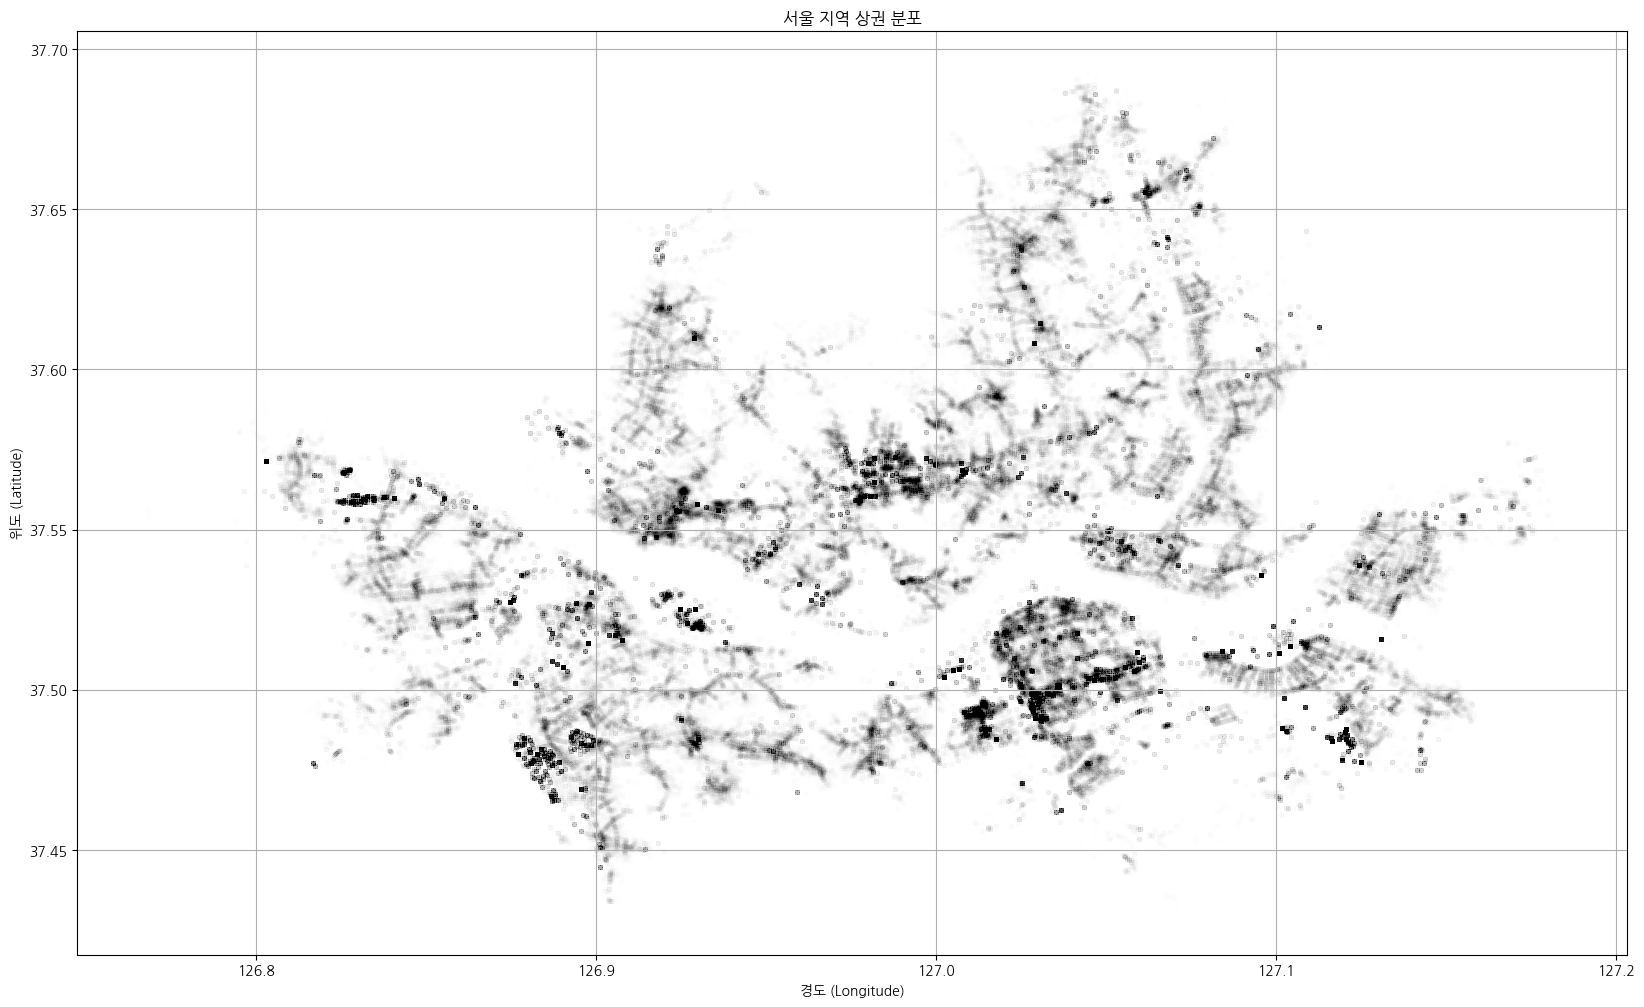

In [11]:
# 샘플 데이터
x_values = df_seoul_simple['경도']
y_values = df_seoul_simple['위도']

# 점산도 그리기
plt.figure(figsize=(20, 12))
plt.scatter(x_values, y_values, color='black', alpha=0.005, s=10)
plt.title('서울 지역 상권 분포')
plt.xlabel('경도 (Longitude)')
plt.ylabel('위도 (Latitude)')
plt.grid(True)
plt.show()

- 서울시 카페 분포 (스타벅스, 이디야, 메가커피)

In [12]:
# 샘플 데이터
x_values = df_seoul_cafe['경도']
y_values = df_seoul_cafe['위도']
categories = df_seoul_cafe['상호명']

# 점산도 그리기
plt.figure(figsize=(20, 12))

# 각 카테고리별로 점 산점도 그리기
for category in categories.unique():
    if '이디야커피' in category :
        plt.scatter(x_values[categories == category], y_values[categories == category], color='blue', label='이디야', alpha=0.05, s=10)
    elif '메가엠지씨커피' in category :
        plt.scatter(x_values[categories == category], y_values[categories == category], color='yellow', label='메가커피', alpha=0.05, s=10)
    else :
        plt.scatter(x_values[categories == category], y_values[categories == category], color='purple', label='기타', alpha=0.05, s=10)
        

# 범례 추가
plt.legend()

plt.title('서울 지역 상권 분포')
plt.xlabel('경도 (Longitude)')
plt.ylabel('위도 (Latitude)')
plt.grid(True)
plt.show()


KeyboardInterrupt: 

# 아악

<img src="https://i.namu.wiki/i/7SO2FDuNnzmK_kE68K_wceSKJqoW8-E4vQnJE3uAItSdqFbjbwHMgITRfWLnssiT7MLWzTz3n6nBedGTFFC1EA.webp" width=1000 height=400 alt=''>